In [7]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA, KernelPCA

from WISE_tools import plot_confusion_matrix

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
        'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
        'WISE_Designation_x', 'N_obs', 'W1chi2', 'W1chi2red', 'W1_MAD',
        'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD', 'W2_EWM', 'W1-W2chi2',
        'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM', 'Unnamed: 0',
        'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
        'W2_Nzeroes', 'W2_

In [6]:
#Throw out binaries, plus a single point with bad 2MASS photometry
training_indices =  np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

#Our features will be color and G/W1 magnitude.
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W2chi2red','W1-W2chi2red',
                   'W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
labels = training_data['Class']

len(labels)

6377

In [8]:
np.logspace(-3,5,9)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])

In [12]:
#A Bayesian Gaussian Mixture with Infinite Dirichlet Process prior
bgm_param_grid = dict(n_components = [5,10,20,30],
                      covariance_type = ['full', 'tied', 'diag', 'spherical'],
                      weight_concentration_prior_type = ['dirichlet_process','dirichlet_distribution'],
                      weight_concentration_prior = np.logspace(-3,5,9)
                     )
bgm_grid = GridSearchCV(BayesianGaussianMixture(n_init = 5), bgm_param_grid, cv=4, n_jobs=-1)                   
bgm_grid.fit(X.values)
best_bgm = bgm_grid.best_estimator_

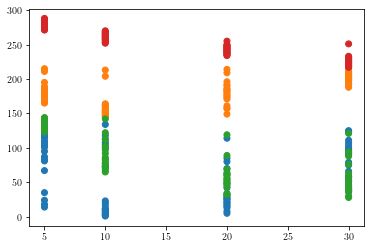

In [19]:
c_dict = {'full':'C0','tied':'C1','diag':'C2','spherical':'C3'}
plt.scatter(bgm_grid.cv_results_['param_n_components'], bgm_grid.cv_results_['rank_test_score'],c=[c_dict[i] for i in bgm_grid.cv_results_['param_covariance_type']])

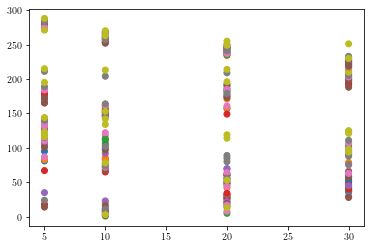

In [21]:
plt.scatter(bgm_grid.cv_results_['param_n_components'], bgm_grid.cv_results_['rank_test_score'],c=[f'C{int(np.log10(i))+3}' for i in bgm_grid.cv_results_['param_weight_concentration_prior']])

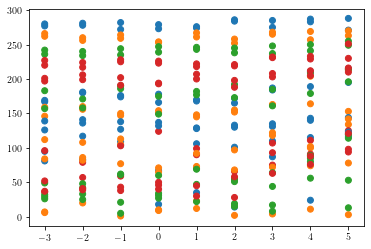

In [31]:
c_dict = {5:'C0',10:'C1',20:'C2',30:'C3'}
plt.scatter(np.log10(bgm_grid.cv_results_['param_weight_concentration_prior'].data.astype(float)), bgm_grid.cv_results_['rank_test_score'],c=[c_dict[i] for i in bgm_grid.cv_results_['param_n_components']])

In [34]:
print(f'Bayesian Gaussian Mixture with {best_bgm.weight_concentration_prior_type} Prior')
print(f'Gamma = {best_bgm.weight_concentration_prior}')
print(f'Covariance Type = {best_bgm.covariance_type}')
print(f'and n_components = {best_bgm.n_components}')

Bayesian Gaussian Mixture with dirichlet_distribution Prior
Gamma = 0.1
Covariance Type = full
and n_components = 10


Text(0, 0.5, 'Weight')

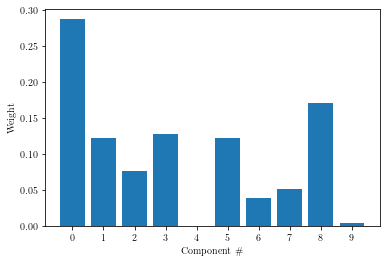

In [45]:
plt.bar(np.arange(best_bgm.n_components),best_bgm.weights_)
plt.xticks(np.arange(best_bgm.n_components))
plt.xlabel('Component \#')
plt.ylabel('Weight')

In [40]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])